In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import json
import pickle
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopWords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path ='./datasets/medical-related.json'
with open(path,'rb') as file:
    data = json.load(file)

In [3]:
patterns = []
tags = []
responses = {}

for intent in data['intents']:
    for pattern in intent['patterns']:
        patterns.append(pattern)
        tags.append(intent['tag'])
    responses[intent['tag']] = intent['responses']

print(len(patterns))
print(len(responses))
print(len(tags))
print(patterns[0:9])
print(tags[0:9])

pickle.dump(tags,open('./model/tags.pkl','wb'))
pickle.dump(patterns,open('./model/patterns.pkl','wb'))
pickle.dump(responses,open('./model/responses.pkl','wb'))

264
59
264
['Hello Pychan', 'Hello', 'Pychan', 'Hai', 'Bye', 'Goodbye', 'good bye', 'Thank you', 'Thank']
['greeting', 'greeting', 'greeting', 'greeting', 'goodbye', 'goodbye', 'goodbye', 'thanks', 'thanks']


In [4]:
def splitDataset(inputs, labels):
    totalData = len(inputs)
    valSize = int(totalData * 0.2)
    valSplit = list(range(0, valSize * 5, 5))
    trainSplit = [i for i in range(totalData) if i not in valSplit]


    trainTexts = [inputs[i] for i in trainSplit]
    valTexts = [inputs[i] for i in valSplit]
    trainLabels = [labels[i] for i in trainSplit]
    valLabels = [labels[i] for i in valSplit]

    trainDataset = tf.data.Dataset.from_tensor_slices((trainTexts, trainLabels))
    valDataset = tf.data.Dataset.from_tensor_slices((valTexts, valLabels))

    return trainDataset, valDataset
    
trainDataset, valDataset = splitDataset(patterns, tags)

In [5]:
print(f"There are {trainDataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {valDataset.cardinality()} sentence-label pairs for validation.\n")

print(trainDataset)
print(valDataset)

There are 212 sentence-label pairs for training.

There are 52 sentence-label pairs for validation.

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>


In [6]:
for data in trainDataset.take(10).as_numpy_iterator():
    print(data)

for data in valDataset.take(10).as_numpy_iterator():
    print(data)

(b'Hello', b'greeting')
(b'Pychan', b'greeting')
(b'Hai', b'greeting')
(b'Bye', b'goodbye')
(b'good bye', b'goodbye')
(b'Thank you', b'thanks')
(b'Thank', b'thanks')
(b'Great', b'thanks')
(b'Awesome', b'thanks')
(b'Cool', b'thanks')
(b'Hello Pychan', b'greeting')
(b'Goodbye', b'goodbye')
(b'Good', b'thanks')
(b'Tell me what you can do', b'pychan')
(b'Which medicine to apply for Cuts?', b'Cuts')
(b'Abrasions', b'Abrasions')
(b'Stings', b'stings')
(b'What to do if I have splinters?', b'Splinter')
(b'Which medicine to apply if I get a sprained?', b'Sprains')
(b'How do you diagnose a strain?', b'Strains')


In [7]:
def standardizeFunc(sentence):
    stopwords = stopWords
    sentence = tf.strings.lower(sentence)

    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@\[\\\]^_`{|}~\']', "")

    return sentence

In [8]:
maxLeght = 30
def fitVectorizer(trainSentences, standardizeFunc):
    vectorizer = tf.keras.layers.TextVectorization(
		standardize=standardizeFunc,
    output_sequence_length=maxLeght
	)
    vectorizer.adapt(trainSentences)
    return vectorizer

In [9]:
textDataset = trainDataset.map(lambda text, label: text)
vectorizer = fitVectorizer(textDataset, standardizeFunc)
vocabSize = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocabSize} words\n")

Vocabulary contains 145 words



In [10]:
def fitLabelEncoder(trainLabel, valLabel):
    labels = trainLabel.concatenate(valLabel) 

    labelEncoder = tf.keras.layers.StringLookup(num_oov_indices=0)
    labelEncoder.adapt(labels)

    return labelEncoder

In [11]:
trainLabels = trainDataset.map(lambda text, label: label)
valLabels = valDataset.map(lambda text, label: label)

labelEncoder = fitLabelEncoder(trainLabels,valLabels)
uniqLabel = len(labelEncoder.get_vocabulary())

print(f'Unique labels: {labelEncoder.get_vocabulary()}')
print(f'Number of unique labels: {uniqLabel}')

Unique labels: ['animal bite', 'thanks', 'Strains', 'Nasal Congestion', 'Itching', 'Eye Pain', 'Burns', 'Abrasions', 'snake bite', 'pychan', 'Sunburn', 'Nosebleeds', 'Itchy Eyes', 'Hypothermia', 'Frostbite', 'Food Poisoning', 'Cuts', 'Cough', 'Blisters', 'Allergic Reactions', 'stings', 'seizure', 'nose bleed', 'greeting', 'Wound', 'Vertigo', 'Testicle Pain', 'Teeth', 'Sun Burn', 'Sprains', 'Splinter', 'Sore Throat', 'Skin problems', 'Rectal bleeding', 'Rash', 'Pulled Muscle', 'Poison', 'Normal Bleeding', 'Insect Bites', 'Heat Stroke', 'Heat Exhaustion', 'Headache', 'Head Injury', 'Gastrointestinal problems', 'Frost bite', 'Fracture', 'Fever', 'Fainting', 'Eye Injury', 'Drowning', 'Diarrhea', 'Cold', 'Choking', 'Chemical Burn', 'CPR', 'Bruises', 'Broken Toe', 'Abdonominal Pain', 'goodbye']
Number of unique labels: 59


In [12]:
def preprocessDataset(dataset, textVectorizer, labelEncoder):
    dataset = dataset.map(lambda text, label: (textVectorizer(text), labelEncoder(label)))
    dataset = dataset.batch(8)

    return dataset

In [13]:
trainProcDataset = preprocessDataset(trainDataset, vectorizer, labelEncoder)
valProcDataset = preprocessDataset(valDataset, vectorizer, labelEncoder)

print(f"batch train dataset: {trainProcDataset.cardinality()}")
print(f"batch validation dataset: {valProcDataset.cardinality()}")

trainBatch = next(trainProcDataset.as_numpy_iterator())
valBatch = next(valProcDataset.as_numpy_iterator())

print(f"Shape train batch: {trainBatch[0].shape}")
print(f"Shape validation batch: {valBatch[0].shape}")

batch train dataset: 27
batch validation dataset: 7
Shape train batch: (8, 30)
Shape validation batch: (8, 30)


In [14]:
def create_model():
    inputLayer = tf.keras.Input(shape=(None,))

    embedLayer = tf.keras.layers.Embedding(input_dim=vocabSize, output_dim=64)(inputLayer)
    bilLSTM1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False))(embedLayer)
    dense1 = tf.keras.layers.Dense(32, activation='relu')(bilLSTM1)
    dropout1 = tf.keras.layers.Dropout(0.3)(dense1)
    outputLayer = tf.keras.layers.Dense(uniqLabel, activation='softmax')(dropout1)
    
    model = Model(inputs=inputLayer, outputs=outputLayer)

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model

In [15]:
model = create_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 64)       │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 59)             │         1,947 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,403 (317.98 KB)

 Trainable params: 81,403 (317.98 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc >= 0.9 and val_acc >= 0.9:
            self.model.stop_training = True

In [17]:
history = model.fit(trainProcDataset, epochs=100, validation_data=valProcDataset, callbacks=myCallback())
model.save('./model/chatbot_model.h5',history)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.0000e+00 - loss: 4.0853 - val_accuracy: 0.0385 - val_loss: 4.0771
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0094 - loss: 4.0736 - val_accuracy: 0.0192 - val_loss: 4.0766
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0082 - loss: 4.0726 - val_accuracy: 0.0192 - val_loss: 4.0754
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0811 - loss: 4.0695 - val_accuracy: 0.0192 - val_loss: 4.0716
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1004 - loss: 4.0616 - val_accuracy: 0.0577 - val_loss: 4.0625
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.0613 - loss: 4.0535 - val_accuracy: 0.0385 - val_loss: 4.0422
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0882 - loss: 4.0149 - val_accuracy: 0.0577 - val_loss: 4.0050
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0998 - loss: 3.9492 - val_accuracy

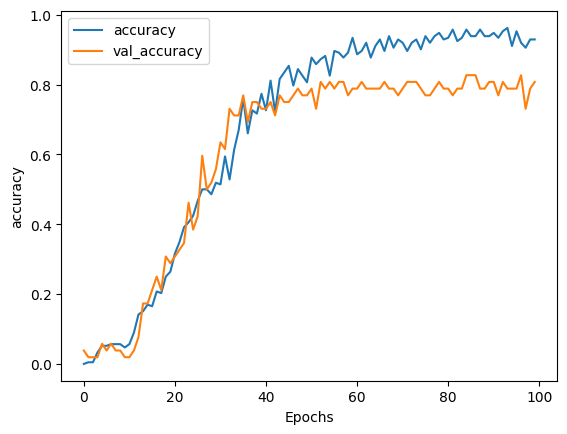

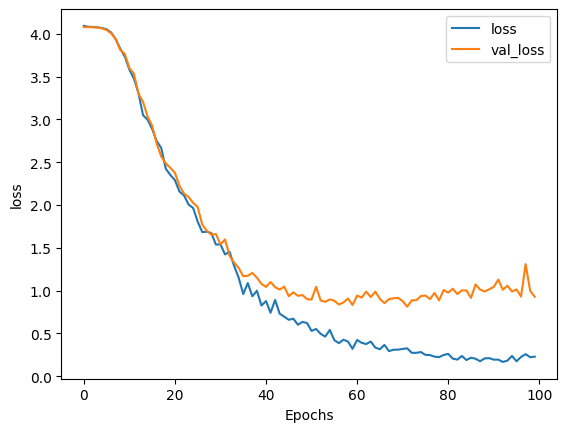

In [18]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")